In [1]:
# Ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, StandardScaler
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, 
                             classification_report, f1_score, accuracy_score,
                             precision_recall_curve, PrecisionRecallDisplay,
                             roc_curve, RocCurveDisplay, auc)
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline

from datassist import experiment
from datassist import log_results

In [3]:
df_titanic = pd.read_csv('data/train.csv')
df_titanic = df_titanic.set_index('PassengerId')

## Preprocessing Pipeline

In [4]:
params = {
    'random_state': 42,
}

In [5]:
# Dropping Name since it is not important for prediction,
# Cabin is also not useful since it has too many missing values.
# Finally, ticket is a random string of characters
X = df_titanic.drop(columns=['Survived', 'Name', 'Cabin', 'Ticket'])
y = df_titanic['Survived']

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=params['random_state'])

In [7]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
299,1,male,NaN,0,0,30.5000,S
885,3,male,25.00,0,0,7.0500,S
248,2,female,24.00,0,2,14.5000,S
479,3,male,22.00,0,0,7.5208,S
306,1,male,0.92,1,2,151.5500,S


In [8]:
# Feature Engineering Steps
# imputer = SimpleImputer(strategy='median')
imputer = KNNImputer()
scaler = QuantileTransformer(
    output_distribution='normal',
    random_state=params['random_state'],
    n_quantiles=500
)
numeric_pipe = Pipeline((
    ('impute', imputer),
    ('scale', scaler),
))
categorical_encoder = OneHotEncoder()

# Identify Features
numeric_features = X.drop(columns=['SibSp', 'Parch']).select_dtypes(include='number').columns
categorical_features = X.select_dtypes(include='object').columns

# Preprocessing pipeline
preproc_pipeline = ColumnTransformer(
    [
        ("numeric", numeric_pipe, numeric_features),
        ("categorical", categorical_encoder, categorical_features),
    ],
    # SibSp and ParCh will be passed through unchanged since
    # they are omitted from `numeric_features`
    remainder="passthrough",
    n_jobs=-1
)

In [9]:
# Two NaNs in 'Embarked'
print(X_train['Sex'].unique())
print(X_train['Embarked'].unique())

['male' 'female']
['S' 'C' 'Q' nan]


In [10]:
clf0 = LinearSVC(random_state=params['random_state'])
clf1 = SVC(random_state=params['random_state'])
clf2 = GradientBoostingClassifier(random_state=params['random_state'])
clf3 = RandomForestClassifier(random_state=params['random_state'])

clf = VotingClassifier(
    estimators=[('svc', clf1), ('gbc', clf2), ('rfc', clf3)],
    voting='hard'
)

pipe = Pipeline((
    ('preprocessing', preproc_pipeline),
    ('classifier', clf)
))

## Results

In [11]:
# Evaluate using cross validation
cv_results = experiment.evaluate_cv(pipe, X_train, y_train, scoring='f1')
experiment.print_cv_results(cv_results, scoring='F1 score')

CV Results
F1 score: 0.74695 +/- 0.04230
training time: 0.27s +/- 0.00s


In [12]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

In [13]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       134
           1       0.83      0.71      0.76        89

    accuracy                           0.83       223
   macro avg       0.83      0.81      0.81       223
weighted avg       0.83      0.83      0.82       223



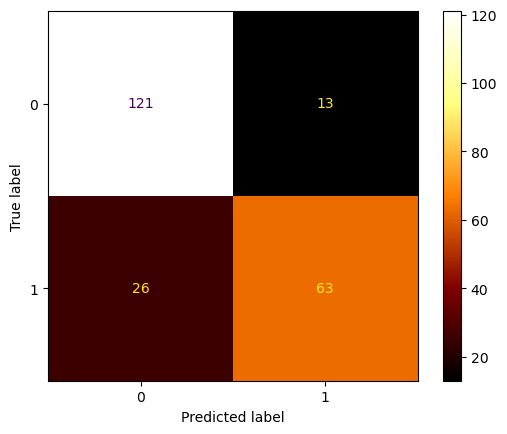

In [14]:
cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display.im_.set_cmap('afmhot')

In [15]:
if hasattr(pipe, 'decision_function'):
    y_score = pipe.decision_function(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_score, pos_label=clf.classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [16]:
if hasattr(pipe, 'decision_function'):
    print(f'AUC score: {auc(fpr, tpr)}')

In [18]:
if hasattr(pipe, 'decision_function'):
    prec, recall, _ = precision_recall_curve(y_val, y_score, pos_label=clf.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

## Log Results

In [19]:
metrics = {
    'F1_score': f1_score(y_val, y_pred),
    'Accuracy': accuracy_score(y_val, y_pred)
}
if hasattr(pipe, 'decision_function'):
    metrics['AUC'] = auc(fpr, tpr)

In [20]:
# Setup experiment logging
helper = log_results.MlflowHelper()
helper.start_local_tracking_server()
helper.setup_experiment('Titanic')

In [21]:
# Evaluate the model on the validation set
def log_model(
    model,
    params: dict | None,
    metrics: dict | None,
    tags: dict | None
):
    return model, params, metrics, tags

In [22]:
helper.run_experiment(
    lambda: log_model(pipe, params, metrics, None),
)

fluent 1


c:\Users\Adam\anaconda3\envs\machine_learning\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
